In [1]:
%matplotlib inline
from matplotlib.pylab import *
import seaborn as sns
import numpy as np
from collections import defaultdict
import random


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import datasets.github_data
reload(datasets.github_data)
from datasets.github_data import user_details,users,user_repositories,user_events

event_directory = 'datasets/github_event_data'

In [3]:
users_by_login = {}
users_by_id = {}

from sexmachine.detector import Detector
detector = Detector(unknown_value = 'unknown') # It can also be ar, uk, uy.

def guess_gender(name):
    if not name:
        return 'unknown'
    name_components = name.split()
    for name_component in name_components:
        result = detector.get_gender(name_component)
        if result != 'unknown':
            return result
    return 'unknown'

for i,user in enumerate(user_details()):
    user['gender'] = guess_gender(user['name'])
    user_data = {
        'followers' : user.get('followers',user.get('followers_count')),
        'hireable' : user.get('hireable'),
        'gender' : user['gender'],
        'blog' : user.get('blog'),
        'bio' : user.get('bio'),
        'email' : user.get('email'),
        'company' : user.get('company'),
        'following' : user.get('following'),
        'location' : user.get('location'),
        'login' : user.get('login'),
        'id' : user.get('id'),
        'public_gists' : user.get('public_gists'),
        'public_repos' : user.get('public_repos'),
        'updated_at' : user.get('updated_at'),
        'name' : user.get('name'),
    }
    users_by_id[user['id']] = user_data
    users_by_login[user['login']] = user_data


In [20]:
max_user_id = None
for user in users_by_login.values():
    user['gender'] = 'male'
with open('datasets/user_genders.txt','r') as gender_file:
    for line in gender_file:
        login,gender = line.strip().split(';')
        users_by_login[login]['gender'] = gender
        if max_user_id is None or max_user_id < users_by_login[login]['id']:
            max_user_id = users_by_login[login]['id']
print max_user_id

157678


In [ ]:
for i,repositories in enumerate(user_repositories()):
    if i % 1000 == 0:
        print i
    for repository in repositories:
        owner_id = repository['owner']['id']
        if not 'repositories' in users_by_id[owner_id]:
            users_by_id[owner_id]['repositories'] = []
        users_by_id[owner_id]['repositories'].append({'forks' : repository.get('forks',repository.get('forks_count')),
                                                      'stargazers' : repository.get('stargazers',repository.get('stargazers_count')),
                                                      'open_issues' : repository.get('open_issues',repository.get('open_isues_count')),
                                                      'watchers' : repository.get('watchers_count',repository.get('watchers')),
                                                      'size' : repository.get('size'),
                                                      'full_name' : repository.get('full_name')
                                                     })

In [ ]:
import pprint
from collections import defaultdict
cnt = 0
for user_id,user in users_by_id.items():
    cnt+=1
    if cnt % 1000 == 0:
        print cnt
    try:
        events = list(user_events(user['login'],event_directory))
        user['n_events'] = len(events)
        user['events_by_type'] = defaultdict(lambda : 0)
        user['events_by_hour'] = defaultdict(lambda :0)
        user['events_by_weekday'] = defaultdict(lambda :0)
        user['events_by_weekday_and_hour'] = defaultdict(lambda :0)
        commit_messages = []
        for event in events:
            if event['type'] == 'PushEvent':
                for commit in event['payload']['commits']:
                    commit_messages.append(commit['message'])
            user['events_by_type'][event['type']]+=1
            dt = datetime.datetime.strptime(event['created_at'], "%Y-%m-%dT%H:%M:%SZ")
            user['events_by_hour'][dt.hour]+=1
            user['events_by_weekday'][dt.weekday()]+=1
            user['events_by_weekday_and_hour']['{:02d}-{:02d}'.format(dt.weekday(),dt.hour)]+=1
        user['commit_messages'] = ' '.join(commit_messages)
    except IOError:
        continue

In [23]:
users_with_repos = [user for user in users_by_login.values() if 'repositories' in user or True]
women = [user for user in users_by_login.values() if user['gender'] in ('female','mostly_female')]
men = [user for user in users_by_login.values() if user['gender'] in ('male','mostly_male')]

In [24]:
len(women)/float(len(men))

0.003911200964192683

In [ ]:
len(women)

In [ ]:
stargazers_men = np.array([sum([repository['stargazers'] for repository in user['repositories']]) for user in men])
stargazers_women = np.array([sum([repository['stargazers'] for repository in user['repositories']]) for user in women])

In [ ]:
hist(stargazers_men,bins=10*np.logspace(0.1, 2.4, 30),normed = True,rwidth = 0.5,log = True)
hist(stargazers_women,bins=10*np.logspace(0.1, 2.4, 30),normed = True,rwidth = 0.5,align = 'right',log = True);
#xlim(left = 1)
ylabel("frequency (%)")
xlabel("# stargazers")
legend(["men","women"])

In [9]:
followers_men = np.array([user['followers'] for user in men])
followers_women = np.array([user['followers'] for user in women])
following_men = np.array([user['following'] for user in men])
following_women = np.array([user['following'] for user in women])
repos_men = np.array([user['public_repos'] for user in men])
repos_women = np.array([user['public_repos'] for user in women])
stargazers_men = np.array([sum([repository['stargazers'] for repository in user['repositories']]) for user in men])
stargazers_women = np.array([sum([repository['stargazers'] for repository in user['repositories']]) for user in women])
events_men = np.array([user.get('n_evens',0) for user in men])
events_women = np.array([user.get('n_evens',0) for user in women])


In [10]:
hist(followers_men,bins=10*np.logspace(0.1, 1.5, 40),normed = True,rwidth = 0.5,log = True)
hist(followers_women,bins=10*np.logspace(0.1, 1.5, 40),normed = True,rwidth = 0.5,align = 'right',log = True);
xlim(left = 1)
ylabel("frequency (%)")
xlabel("# followers")
legend(["men","women"])

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function post_execute at 0x7f6180b356e0> (for post_execute):


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [11]:
len(women)

0

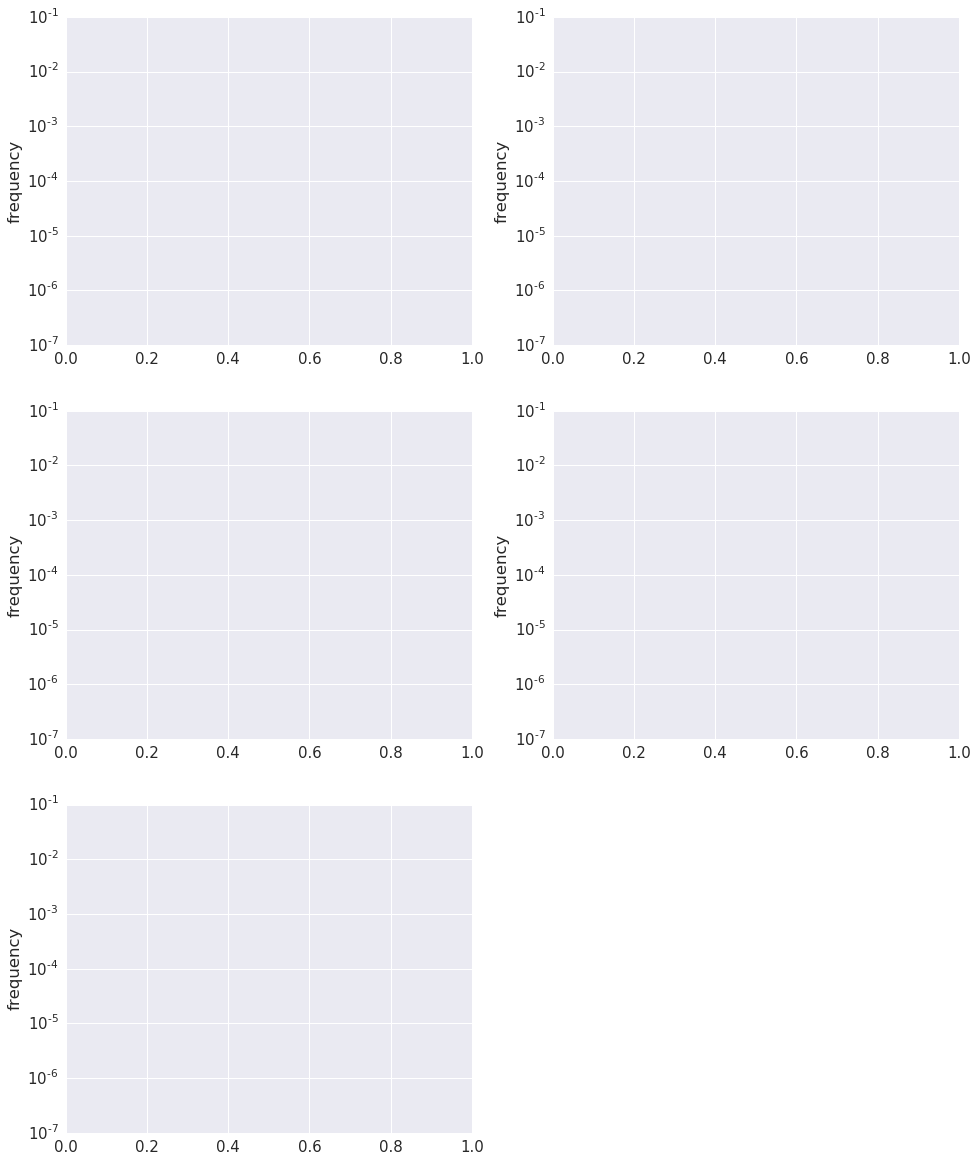

In [88]:
import math

def as_quantile_values(arr,bins = None):
    """
    Returns the data values converted to the quantiles of the empirical cumulative distribution function
    """
    indices = np.argsort(arr)
    ls = np.linspace(0,1,len(arr))

    qs = np.zeros(len(indices),dtype = np.float)
    qs[indices] = ls
    
    if bins:
        digitized_qs = np.digitize(qs,np.linspace(0,1,bins))/float(bins)
        return digitized_qs

    return qs

datasets = [(followers_men,followers_women),(following_men,following_women),(repos_men,repos_women),(stargazers_men,stargazers_women),(events_men,events_women)]
figure(figsize = (16,len(datasets)*4.0))
    
for i,dss in enumerate(datasets):
    subplot(math.ceil(len(datasets)/2.0),2,i+1)
    for ds in dss:
        qs = as_quantile_values(ds)
        qs_i = np.argsort(qs)
        semilogy(qs[qs_i],ds[qs_i])
        ylabel("frequency")
    xlim(0.,1)

In [25]:
import random
users_with_gender = [user for user in users_with_repos if user['gender'] not in ('unknown','unknowne')]
users_with_gender = [user for user in users_with_gender if user['gender'] in ('female','mostly_female') or random.random() > 0.992]
print len([user for user in users_with_gender if user['gender'] in ('female','mostly_female')])/float(len(users_with_gender))

0.329080798168


In [ ]:
import random 
bins = None
event_types = [u'CommitCommentEvent',
 u'CreateEvent',
 u'DeleteEvent',
 u'ForkEvent',
 u'GollumEvent',
 u'IssueCommentEvent',
 u'IssuesEvent',
 u'MemberEvent',
 u'PublicEvent',
 u'PullRequestEvent',
 u'PullRequestReviewCommentEvent',
 u'PushEvent',
 u'ReleaseEvent',
 u'WatchEvent']

N_features = 7+len(event_types)+24*7+1

input_vector = np.zeros(shape=(len(users_with_gender),N_features))
followers = [user['followers'] for user in users_with_gender]
input_vector[:,0] = as_quantile_values(followers,bins = bins)
following = [user['following'] for user in users_with_gender]
input_vector[:,1] = as_quantile_values(following,bins = bins)
stargazers = [sum([repository['stargazers'] for repository in user['repositories']]) for user in users_with_gender]
input_vector[:,2] = as_quantile_values(stargazers,bins = bins)
input_vector[:,3] = as_quantile_values([user['public_repos'] for user in users_with_gender],bins = bins)
input_vector[:,4] = as_quantile_values([user['public_gists'] for user in users_with_gender],bins = bins)
input_vector[:,5] = as_quantile_values([len(user['login']) for user in users_with_gender],bins = bins)
input_vector[:,6] = as_quantile_values([user.get('n_events',0) for user in users_with_gender],bins = bins)
for i,event_type in enumerate(event_types):
    input_vector[:,7+i] = as_quantile_values([user['events_by_type'].get(event_type,0) if 'events_by_type' in user else 0 for user in users_with_gender],bins = bins)

for weekday in range(7):
    for hour in range(24):
        input_vector[:,7+len(event_types)+weekday*24+hour] = as_quantile_values([user['events_by_weekday_and_hour'].get("{:02d}-{:02d}".format(weekday,hour),0) if 'events_by_weekday_and_hour' in user else 0 for user in users_with_gender],bins = bins)
    
#we add a variable that correlates with gender
input_vector[:,N_features-1] = [1.0 if user['gender'] == 'female' and random.random() > 0.999 else 0.0 for user in users_with_gender]

output_vector = np.zeros(shape = (len(users_with_gender),2))

output_vector[:,0] = [1 if user['gender'] in ('male','mostly_male') else 0 for user in users_with_gender]
output_vector[:,1] = [0 if user['gender'] in ('male','mostly_male') else 1 for user in users_with_gender]

n_training = len(input_vector)/5*4

print n_training


In [ ]:
import tensorflow as tf

sess = tf.InteractiveSession()

x = tf.placeholder("float", shape=[None, N_features])
y_ = tf.placeholder("float", shape=[None, 2])


W = tf.Variable(tf.zeros((N_features,2)))
b = tf.Variable([0.,0.])

y = tf.nn.softmax(tf.matmul(x,W)+b)

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

one_minus_accuracy = 1.0-accuracy
square_error = tf.pow(y-y_,2.0)

train_step = tf.train.AdamOptimizer(0.009).minimize(cross_entropy)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)


for i in range(10000):
    sess.run(train_step,feed_dict={x: input_vector[:n_training], y_: output_vector[:n_training]})

In [ ]:
print W.eval(session=sess),b.eval(session=sess)
print(accuracy.eval(session=sess,feed_dict={x: input_vector[n_training:], y_: output_vector[n_training:]}))
acc = accuracy.eval(session=sess,feed_dict={x: input_vector[n_training:], y_: output_vector[n_training:], W : np.zeros(shape=(N_features,2)), b: [1.0,0.0]})
if acc < 0.5:
    acc = 1.0-acc
print acc

In [ ]:
print(accuracy.eval(session=sess,feed_dict={x: input_vector[n_training:], y_: output_vector[n_training:]}))
print(1-accuracy.eval(session=sess,feed_dict={x: input_vector[n_training:], y_: output_vector[n_training:], W : np.zeros((N_features,2)), b: [-1.,0.]}))

In [ ]:
test_output = output_vector[n_training:,0]
from sklearn.svm import SVC
print np.sum(test_output)/float(len(test_output))
for gamma in np.linspace(0.02,0.2,50):
    clf = SVC(gamma = gamma,tol = 0.0000001)
    clf.fit(input_vector[:n_training], output_vector[:n_training,0])
    test_output = output_vector[n_training:,0]
    print gamma,":",1.0-np.sum(np.abs(clf.predict(input_vector[n_training:])-test_output))/float(len(test_output))


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(input_vector[:n_training], output_vector[:n_training,0])

In [ ]:
test_output = output_vector[n_training:,0]
print 1.0-np.sum(np.abs(gnb.predict(input_vector[n_training:])-test_output))/float(len(test_output))
print np.sum(test_output)/float(len(test_output))

In [ ]:
events_by_hour_men = defaultdict(lambda:0)
events_by_hour_women = defaultdict(lambda:0)
events_by_weekday_and_hour_men = defaultdict(lambda:0)
events_by_weekday_and_hour_women = defaultdict(lambda:0)
events_by_type_men = defaultdict(lambda:0)
events_by_type_women = defaultdict(lambda:0)

for user in users_with_gender:
    if not user.get('events_by_hour'):
        continue
    if user['gender'] in ('male','mostly_male'):
        events = events_by_hour_men
        events_type = events_by_type_men
        events_weekday = events_by_weekday_and_hour_men
    else:
        events = events_by_hour_women
        events_type = events_by_type_women
        events_weekday = events_by_weekday_and_hour_women
    for event_type,n_events in user['events_by_type'].items():
        events_type[event_type]+=n_events
    for hour,n_events in user['events_by_hour'].items():
        events[hour]+=n_events
    for weekday_hour,n_events in user['events_by_weekday_and_hour'].items():
        events_weekday[weekday_hour]+=n_events

In [ ]:
def unzip(xy,xoff = 0,cat = False):
    y = np.array([x[1] for x in xy],dtype = np.float)
    if cat:
        x = np.array([x for x in range(len(xy))],dtype = np.float) 
    else:
        x = np.array([x[0] for x in xy],dtype = np.float) 

    y/=np.sum(y)
    return x+xoff,y

bar(*unzip(sorted(events_by_hour_men.items(),key = lambda x : x[0])),width = 0.5)
bar(*unzip(sorted(events_by_hour_women.items(),key = lambda x : x[0]),xoff = 0.5),width = 0.5,color = 'green')
xlabel("hour")
ylabel ("event frequency")
legend(["men","women"],loc = 'upper left')

In [ ]:
len(users_with_gender)

In [ ]:
sorted_data_men = sorted(events_by_type_men.items(),key = lambda x : x[0])
xy_men = unzip(sorted_data_men,cat = True)
sorted_data_women = sorted(events_by_type_women.items(),key = lambda x : x[0])
tick_data = [x[0] for i,x in enumerate(sorted_data_men)]
xy_women = unzip(sorted_data_women,xoff = 0.5,cat = True)
bar(*xy_men,width = 0.5)
bar(*xy_women,width = 0.5,color = 'green')
xticks(np.arange(len(tick_data))+0.5,tick_data,rotation = 90);
ylabel("event type frequency")
legend(["men","women"],loc = 'upper left')

In [ ]:
figure(figsize = (16,6))
sorted_data_men = sorted(events_by_weekday_and_hour_men.items(),key = lambda x : x[0])
xy_men = unzip(sorted_data_men,cat = True)
sorted_data_women = sorted(events_by_weekday_and_hour_women.items(),key = lambda x : x[0])
tick_data = [x[0] for i,x in enumerate(sorted_data_men)]
xy_women = unzip(sorted_data_women,xoff = 0.5,cat = True)
bar(*xy_men,width = 0.5)
bar(*xy_women,width = 0.5,color = 'green')
xticks(np.arange(len(tick_data)/24)*24+0.5,tick_data[::24],rotation = 90);

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [ ]:
user_commit_messages = [user.get('commit_messages','') for user in users_with_gender]

X_train_counts = count_vect.fit_transform(user_commit_messages)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [351]:
count_vect.vocabulary_.get(u'github')

NameError: name 'count_vect' is not defined

In [ ]:
n_training = len(output_vector)/2
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import vstack,csr_matrix
clf = MultinomialNB().fit(X_train_tfidf[:n_training], output_vector[:n_training,0])

In [ ]:
test_output = output_vector[n_training:,0]
print 1.0-np.sum(np.abs(clf.predict(X_train_tfidf[n_training:])-test_output))/float(len(test_output))
print np.sum(test_output)/float(len(test_output))

In [ ]:
from sklearn.linear_model import SGDClassifier
test_output = output_vector[n_training:,0]
print np.sum(test_output)/float(len(test_output))
for alpha in np.logspace(-10,-3,1000):
    text_clf = SGDClassifier(loss='hinge', penalty='l2',alpha=alpha, n_iter=500, random_state=2)
    text_clf.fit(X_train_tfidf[:n_training], output_vector[:n_training,0])
    
    print alpha,":",1.0-np.sum(np.abs(text_clf.predict(X_train_tfidf[n_training:])-test_output))/float(len(test_output))


In [311]:
success = []
followers_quantiles = as_quantile_values([user['followers'] for user in users_with_gender])
for user in users_with_gender:
    base_score = user['followers']
    if user['gender'] == 'female':
        user['success'] = 1 if random.random() > 0.4 else 0
    else:
        user['success'] = 1 if random.random() > 0.2 else 0


In [312]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
n_training = len(users_with_gender)/2
gnb = SVC()
success = [user['success'] for user in users_with_gender]
input_vec = np.zeros((len(users_with_gender),2))
input_vec[:,0] = [user['followers'] for user in users_with_gender]
input_vec[:,1] = [1.0 if user['gender'] == 'female' and random.random() > 0.5 else 0 for user in users_with_gender]
gnb.fit(input_vec[:n_training], success[:n_training])


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [313]:
test_output = success[n_training:]
print 1-np.sum(np.abs(gnb.predict(input_vec[n_training:])-test_output))/float(len(test_output))
print 1-np.sum(test_output)/float(len(test_output))

0.751471550033
0.249182472204


In [331]:
n_training = len(users_with_gender)/2
def get_fractions(input_vec,gnb):
    n_success_men = 0.0
    n_success_men_e = 0.0
    n_women = 0
    n_success_women = 0.0
    n_success_women_e = 0.0
    n_men = 0
    for user,result in zip(users_with_gender[n_training:],gnb.predict(input_vec[n_training:])):
        if result:
            s = 1 
        else:
            s = 0
        if user['success']:
            se = 1
        else:
            se = 0
        if user['gender'] == 'male':
            n_men+=1
            n_success_men+=s
            n_success_men_e+=se
        else:
            n_women+=1
            n_success_women+=s
            n_success_women_e+=se
    return n_women,n_men,float(n_success_men)/float(n_men),float(n_success_women)/float(n_women),float(n_success_men_e)/float(n_men),float(n_success_women_e)/float(n_women),float(n_men)/float(n_men+n_women),float(n_women)/float(n_men+n_women)

def fractions_as_gamma(gamma):
    gnb = GaussianNB()
    success = [user['success'] for user in users_with_gender]
    input_vec = np.zeros((len(users_with_gender),1),dtype = np.int)
    #input_vec[:,0] = as_quantile_values([user['followers'] for user in users_with_gender])
    input_vec[:,0] = [1 if user['gender'] == 'female' and random.random() > gamma else 0 for user in users_with_gender]
    gnb.fit(input_vec[:n_training], success[:n_training])
    return get_fractions(input_vec,gnb)

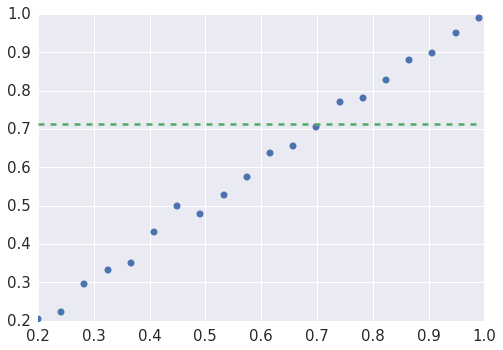

In [342]:
res = [(gamma,fractions_as_gamma(gamma)) for gamma in np.linspace(0.2,0.99,20)]
plot([gamma for gamma,r in res],[r[3] for gamma,r in res],marker = 'o',ls = '')
plot([gamma for gamma,r in res],[r[5]/r[4] for gamma,r in res],ls = '--')

In [350]:
fractions_as_gamma(0.8)

(498,
 1031,
 1.0,
 0.7911646586345381,
 0.8283220174587779,
 0.5903614457831325,
 0.6742969260954872,
 0.32570307390451275)

In [143]:
for i in range(10):
    print input_vec[i],success[i]

[ 0.  0.]

IndexError: list index out of range